# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Volume Reversal Strategy

In this notebook, we will implement a trading strategy based on price movements corresponding to the trading volume of the security.

## Import the libraries
First we will import the necessary libraries. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Stock data 
We will now read the data for Apple(AAPL) from CSV file. We will be saving the data in the dataframe 'data'. We will then, print the data to visualise it by using the head() function which prints the top 5 rows of the dataset.

You can download the data from the downloadable unit of this course in the last section. You can also fetch the US equity data from Yahoo finance.

In [2]:
import pandas as pd
data = pd.read_csv('../data_modules/aaple_data_18_19.csv',
                   index_col=0, parse_dates=True)
data.head()

,Open,High,Low,Close,Volume
date,,,,,
2018-06-19,185.14,186.33,183.45,185.69,33578455
2018-06-20,186.35,187.20,185.73,186.50,20628701
2018-06-21,187.25,188.35,184.94,185.46,25711898
2018-06-22,186.12,186.15,184.70,184.92,27200447
2018-06-25,183.40,184.92,180.73,182.17,31663096


## Price change for the last 5 days
We will calculate the difference between the current price of the stock and the price of the stock five days ago. We will use shift() function for fetching the data for days in the past. data['Close'].shift(1) will give us yesterday's closing price, data['Close'].shift(6) will give us the closing price 6 days earlier. The difference of the two will give us the price change for the last 5 days and store this in a new column called 'pr_change'.

In [3]:
data['pr_chg'] = data['Close'].shift(1)-data['Close'].shift(6)

## Standard deviation of price change
Next, we will calculate 100 days standard deviation of price change and store the value in a new column called 'std_100day' by using the rolling.std() function. This will help us to measure volatility of change in price for the stock.

In [4]:
data['std_100day'] = data['pr_chg'].rolling(window=100).std()

## Average volume traded
Now we will calculate the last 5 day's (previous week's) average traded volume by using the shift() and rolling.mean() functions and store the values in a new column '5d_avg_vol'. 

In [5]:
data['5d_avg_vol'] = data['Volume'].shift(1).rolling(window=5).mean()

## Average volume traded between last 5 to 10 days
Next, we will calculate the average traded volume for last 5 to 10 days by shifting the values in column '5d_avg_vol' and store this value in a new column 'past 5d_avg_vol'.

In [6]:
data['past 5d_avg_vol'] = data['5d_avg_vol'].shift(5)

## Signal column
To store the trading signals we will create a 'signal' column and store 0 values in it. 

In [7]:
data['signal'] = 0

## Buy signal 
A signal to buy will be triggered when the absolute value of the 5 day price change is greater than the 100 day standard deviation and the 5 day average traded volume is less than the 5 day average volume beginning 10 days prior and the 5 day price change is negative. We will assign a value of 1 to the column 'signal' when these conditions are met.
 
Please note that we are comparing the 5 day average volume with 5 day average volume beginning 10 days prior instead of considering 75% of the 5 day average volume beginning 10 days prior as was stated in the video lecture because the number of signals generated was very low with the 75% condition. 

In [8]:
data.loc[((data['pr_chg'].abs() > data['std_100day']) & (data['5d_avg_vol'] < data['past 5d_avg_vol'])
          & (data['pr_chg'] < 0)), 'signal'] = 1

## Sell signal 
Similarly, a sell signal will be generated when the value of price change is positive. In this case, we store a value of -1 to the signal column.

In [9]:
data.loc[((data['pr_chg'].abs() > data['std_100day'])
          & (data['5d_avg_vol'] < data['past 5d_avg_vol'])
          & (data['pr_chg'] > 0)), 'signal'] = -1

## c_signal and exit columns 
Next, we will create two columns, c_signal and exit, to measure the count of continuous signals and the exit criterion respectively and store 0 values in them.

In [10]:
data['c_signal'] = 0
data['exit'] = 0

## Entry and Exit signal

In this block of code, we will implement the core of the strategy. Here we will check for the last entry signal, if the signal is more than 5 days old then we exit the position, else we will continue to hold it until the signal is 5 days old or a counter signal is generated.

Let us understand what we do in each of the if statements below:

First, we check if a new signal is generated, if it is then we will assign the c_signal column equal to the new signal, and then we update the exit criterion according to the signal generated. In this case, we will check if the signal is 1 if it is so, then we will mark the exit count as 1 otherwise, we will mark it as -1.

Next, we will check if the entry signal is same as the existing position. If it is so, then we will update the exit criterion depending on the position. For example, if you are already long then your c_signal would be 1, hence it will be incremented by 1. If you are short then your c_signal is -1 and your exit will be reduced by 1.

After this, we will update the exit criterion for an already existing long trade. We check if the exit value of the c_signal is less 5 days old, if this is the case then we verify if the continuing signal is same as the previous days then we increment the exit by 1.


Just as in the above step, we will update the exit criterion for an already existing short trade.


Next, we will update the exit criterion to 0 on the fifth day after entering the trade. This is one of the conditions of the strategy and accordingly we will close all positions on their 5th day.

In [11]:
for i in range(len(data)):
    if (data.iloc[i]['signal'] != 0) & (data.iloc[i]['signal']
                                        != data.iloc[i - 1]['c_signal']):
        data.iloc[i, data.columns.get_loc('c_signal')] = data.iloc[i,
                                                                   data.columns.get_loc('signal')]
        if data['signal'][i] == 1:
            data.iloc[i, data.columns.get_loc('exit')] = 1
        else:
            data.iloc[i, data.columns.get_loc('exit')] = -1
    
    if (data['signal'][i] != 0) & (data['signal'][i] == data['c_signal'
                                                             ][i - 1]):
        data.iloc[i, data.columns.get_loc('c_signal')] = data['c_signal'
                                                              ][i - 1]
        if data['c_signal'][i - 1] == 1:
            data.iloc[i, data.columns.get_loc('exit')] = int(data['exit'
                                                                  ][i - 1]) + 1
        else:
            data.iloc[i, data.columns.get_loc('exit')] = int(data['exit'
                                                                  ][i - 1]) - 1
    if (data['signal'][i] == 0) & (data['exit'][i - 1] < 5) \
            & (data['exit'][i - 1] > 0):
        data.iloc[i, data.columns.get_loc('c_signal')] = data['c_signal'
                                                              ][i - 1]
        data.iloc[i, data.columns.get_loc('exit')] = int(data['exit'][i
                                                                      - 1]) + 1
    if (data['signal'][i] == 0) & (data['exit'][i - 1] > -5) \
            & (data['exit'][i - 1] < 0):
        data.iloc[i, data.columns.get_loc('c_signal')] = data['c_signal'
                                                              ][i - 1]
        data.iloc[i, data.columns.get_loc('exit')] = int(data['exit'][i
                                                                      - 1]) - 1
    if (data['signal'][i] == 0) & ((data['exit'][i - 1] == 5)
                                   | (data['exit'][i - 1] == -5)):
        data.iloc[i, data.columns.get_loc('c_signal')] = 0
        data.iloc[i, data.columns.get_loc('exit')] = 0

In [12]:
print(data.tail())

              Open    High     Low   Close    Volume  pr_chg  std_100day  \
date                                                                       
2019-06-11  194.86  196.00  193.60  194.81  26932882   19.28    7.068511   
2019-06-12  193.95  195.97  193.39  194.19  18253189   15.17    7.196139   
2019-06-13  194.70  196.79  193.60  194.15  21674625   11.65    7.263067   
2019-06-14  191.55  193.59  190.30  192.74  18761474    8.93    7.292381   
2019-06-17  192.90  194.96  192.17  193.89  14669144    2.59    7.291401   

            5d_avg_vol  past 5d_avg_vol  signal  c_signal  exit  
date                                                             
2019-06-11  28034588.6       29017478.0      -1        -1    -1  
2019-06-12  27227572.8       29621438.2      -1        -1    -2  
2019-06-13  24923525.2       29879890.6      -1        -1    -3  
2019-06-14  24753188.0       30141470.4      -1        -1    -4  
2019-06-17  22368604.2       30869632.2       0        -1    -5  


## Market returns
We will now calculate the returns of the market for each day by dividing the current day closing price by previous day's closing price.

In [13]:
data['return'] = data['Close'].pct_change()

## Strategy returns
It is now time to calculate the returns of the strategy by taking the product of return and its corresponding value in the column c_signal.

In [14]:
data['str_return'] = data['return']*data['c_signal']

## Cumulative returns
We will create two new columns to calculate cumulative returns of the strategy and that of the market. 

In [15]:
data['cu_str_return'] = 0
data['cu_mar_return'] = 0

## Returns after the first hundred days 
Next, we will calculate the strategy and market returns after the first hundred days as the first signal will need hundred days of data to calculate the standard deviation in the std_100 day column.

In [16]:
data.iloc[100:,data.columns.get_loc('cu_str_return')]= (data['str_return'][100:]+1).cumprod()

In [17]:
data.iloc[100:, data.columns.get_loc('cu_mar_return')] = (
    data['return'][100:]+1).cumprod()

In [18]:
data[['cu_mar_return', 'cu_str_return', 'c_signal']].tail()

,cu_mar_return,cu_str_return,c_signal
date,,,
2019-06-11,0.927888,1.108308,-1
2019-06-12,0.924935,1.111836,-1
2019-06-13,0.924744,1.112065,-1
2019-06-14,0.918028,1.120141,-1
2019-06-17,0.923506,1.113458,-1


## Plot the returns 
We will now plot the returns of the market and that of the strategy on a chart.

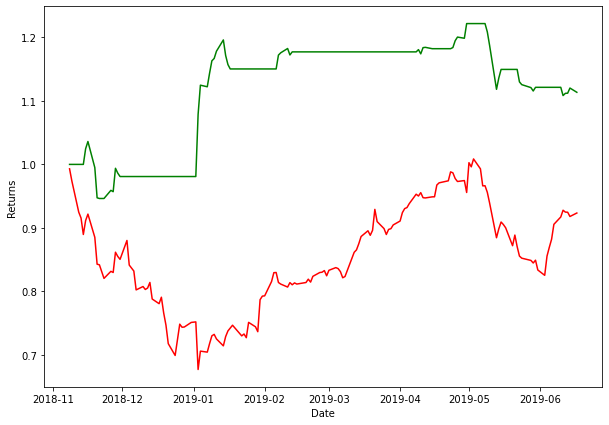

In [19]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(10, 7))
plt.plot(data['cu_str_return'][100:], color='g', label='Strategy Returns')
plt.plot(data['cu_mar_return'][100:], color='r', label='Market Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

## Sharpe ratio 
To evaluate the returns of the strategy we will calculate the Sharpe ratio by dividing the difference between the cumulative strategy returns and that of market returns by standard deviation of cumulative strategy returns.

In [20]:
(data['cu_str_return'].iloc[-1]-data['cu_mar_return'].iloc[-1]) / \
    data['cu_str_return'].std()

0.34292826791401304

#### Note: The number of signals generated may increase if we apply the strategy to a portfolio of stocks instead of just one stock.